The empirical exercise should focus on how the sector and factor tilting works when a crisis comes, better diversification provided, consistent risk factor contributions, and greater resilience to economic shocks

I should present two applications:
1. single name 
2. sector rotation strategy

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import cvxpy as cp
from tqdm.notebook import tqdm
from regimeaware.routines import cfg
from itertools import product
from scipy.stats import entropy
from regimeaware.core import utils

rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)

# CRSP data set loading
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp_daily.pkl')
crsp['mktcap'] = crsp['shrout'].mul(crsp['prc']).abs().replace(0, np.nan)
crsp['dollar_vol'] = crsp['prc'].mul(crsp['vol'])
crsp['industry'] = crsp['siccd'].apply(utils.assign_industry)

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Monthly performance time series
rf = pd.read_pickle(f'{cfg.data_fldr}/ff_daily.pkl')['rf']
rf = rf.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)
rt = pd.pivot_table(crsp, index='date', columns='permno', values='ret')
rt = rt.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)
rt = rt.replace(0, np.nan)

C:\Users\franc\AppData\Local\Temp\ipykernel_11836\2464336238.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)
C:\Users\franc\AppData\Local\Temp\ipykernel_11836\2464336238.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rf = rf.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)
C:\Users\franc\AppData\Local\Temp\ipykernel_11836\2464336238.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rt = rt.add(1).groupby(pd.Grouper(freq=cfg.rebalance_freq)).prod().sub(1)


$$
\begin{equation}
\begin{aligned}
& \underset{w}{\text{argmin}} & & \gamma \left( w^{T} F^{T} \Sigma_{f} F w + w^{T} E w \right) - w^{T} \mu_{f} \\
& \text{s.t.} & & (w - b)^{T} \Sigma (w - b) \leq \bar{\sigma}^{2} \\
& & & \sum_{i=1}^{N} w_i = 1 \\
& & &  w_i \geq 0 \; ; \; \forall \; i =1, \ldots, N \\
\end{aligned}
\end{equation}
$$

In [11]:
indu_t = crsp['industry'].xs(as_of_dt).reindex(tradable_ids)

In [2]:
collect_wt = {}
collect_bm = {}

crsp_dts = crsp.index.get_level_values('date').unique()
for g, dt in product(cfg.gamma_iter, rebalance_dts):
    print(f'Gamma: {g}, Date: {dt.strftime("%Y %b")}', end='       \r')
    as_of_dt = crsp_dts.asof(dt)
    loadings_t = utils.unpack_betas(factor_loadings.xs(dt))
    tradable_ids = loadings_t.join(crsp[['ret', 'mktcap']].xs(as_of_dt)).dropna().index
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = loadings_t.reindex(tradable_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(tradable_ids))

    b = crsp['mktcap'].xs(as_of_dt).reindex(tradable_ids)
    b = np.divide(b, b.sum())
    collect_bm[dt] = b.copy()
    b = b.values.reshape(-1, 1)

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ (w - b),
        w >= 0
    ]

    gamma.value = g

    prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_wt[(g, dt)] = pd.Series(w.value.flatten(), index=tradable_ids)

wts = pd.DataFrame.from_dict(collect_wt, orient='index').fillna(0)
wts.index.names = ['gamma', 'date']

collect_bt = {}
for g in cfg.gamma_iter:
    wt = wts.xs(g)
    collect_bt[g] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

# Backtests
bt = pd.DataFrame.from_dict(collect_bt)
bt.columns = [f'Gamma: {x}' for x in bt.columns]

# Benchmark
bm_wt = pd.DataFrame.from_dict(collect_bm, orient='index')
bm_rt = bm_wt.shift(1).mul(rt.reindex(bm_wt.columns, axis=1)).dropna(how='all').sum(axis=1)

# Stats/plots
df = bm_rt.to_frame(name='Benchmark').join(bt).add(1).cumprod()
df = df.div(df.iloc[0])
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12))
display(ir.sort_values())
display(sr.sort_values())
display(tracking.std().mul(np.sqrt(12)).sort_values())

In [5]:
zero_flags = np.isclose(bm_wt, 0, atol=1e-8)
total = bm_wt.mask(zero_flags).count(axis=1)
wts.mask(zero_flags).count(axis=1).groupby('gamma').mean()

gamma
90     446.589212
200    685.634855
300    832.136929
dtype: float64

Gamma: 300    0.351864
Gamma: 200    0.361555
Gamma: 90     0.389098
dtype: float64

Benchmark     0.727444
Gamma: 90     0.761235
Gamma: 300    0.763085
Gamma: 200    0.763865
dtype: float64

Gamma: 300    0.031682
Gamma: 200    0.041569
Gamma: 90     0.068549
dtype: float64

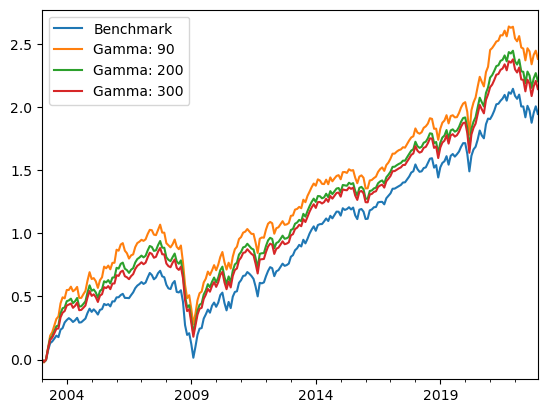

In [6]:
df = bm_rt.to_frame(name='Benchmark').join(bt).add(1).cumprod()
df = df.div(df.iloc[0])
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12))
display(ir.sort_values())
display(sr.sort_values())
display(tracking.std().mul(np.sqrt(12)).sort_values())


Anchor the risk aversion parameter to TEV, enough to generate around 6%

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


TEV: 0.08                    0.174448
TEV: 0.06999999999999999     0.205832
TEV: 0.060000000000000005    0.228197
TEV: 0.05                    0.263513
TEV: 0.04                    0.299356
TEV: 0.03                    0.354056
TEV: 0.01                    0.375682
TEV: 0.02                    0.408522
dtype: float64

TEV: 0.08                    0.530810
TEV: 0.06999999999999999     0.563043
TEV: 0.060000000000000005    0.591873
TEV: 0.05                    0.631082
TEV: 0.04                    0.671585
TEV: 0.03                    0.724189
Benchmark                    0.727444
TEV: 0.02                    0.771675
TEV: 0.01                    0.773617
dtype: float64

TEV: 0.01                    0.039565
TEV: 0.02                    0.071387
TEV: 0.03                    0.098085
TEV: 0.04                    0.119921
TEV: 0.05                    0.138713
TEV: 0.060000000000000005    0.155264
TEV: 0.06999999999999999     0.168501
TEV: 0.08                    0.178549
dtype: float64

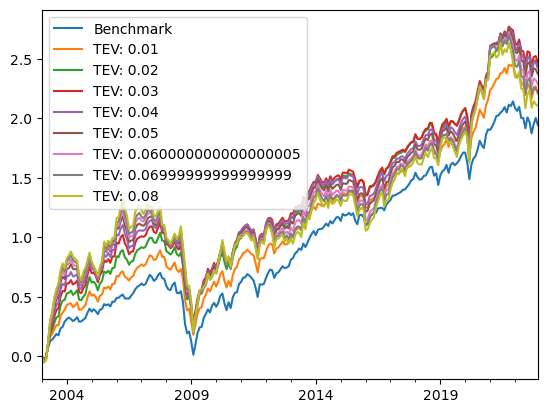

In [33]:
collect_wt = {}
collect_bm = {}
tev_to_test = np.arange(start=0.01, stop=.08, step=.01)
crsp_dts = crsp.index.get_level_values('date').unique()
for dt, tev in product(rebalance_dts, tev_to_test):
    print(f'TEV: {tev}, Date: {dt.strftime("%Y %b")}', end='       \r')
    as_of_dt = crsp_dts.asof(dt)
    loadings_t = utils.unpack_betas(factor_loadings.xs(dt))
    tradable_ids = loadings_t.join(crsp[['ret', 'mktcap']].xs(as_of_dt)).dropna().index
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = loadings_t.reindex(tradable_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(tradable_ids))

    b = crsp['mktcap'].xs(as_of_dt).reindex(tradable_ids)
    b = np.divide(b, b.sum())
    collect_bm[dt] = b.copy()
    b = b.values.reshape(-1, 1)

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ (w - b),
        w >= 0,
        port_risk <= (tev ** 2) / 12
    ]

    gamma.value = g

    prob = cp.Problem(cp.Maximize(port_return), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_wt[(tev, dt)] = pd.Series(w.value.flatten(), index=tradable_ids)

wts = pd.DataFrame.from_dict(collect_wt, orient='index').fillna(0)
wts.index.names = ['tev', 'date']

collect_bt = {}
for tev in tev_to_test:
    wt = wts.xs(tev)
    collect_bt[tev] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)


# Backtests
bt = pd.DataFrame.from_dict(collect_bt)
bt.columns = [f'TEV: {x}' for x in bt.columns]

# Benchmark
bm_wt = pd.DataFrame.from_dict(collect_bm, orient='index')
bm_rt = bm_wt.shift(1).mul(rt.reindex(bm_wt.columns, axis=1)).dropna(how='all').sum(axis=1)

df = bm_rt.to_frame(name='Benchmark').join(bt).add(1).cumprod()
df = df.div(df.iloc[0])
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = df.pct_change().mean().div(df.pct_change().std()).mul(np.sqrt(12))
display(ir.sort_values())
display(sr.sort_values())
display(tracking.std().mul(np.sqrt(12)).sort_values())

In [30]:
zero_flags = np.isclose(bm_wt, 0, atol=1e-8)
total = bm_wt.mask(zero_flags).count(axis=1)
zero_flags = np.isclose(wts, 0, atol=1e-8)
wts.mask(zero_flags).count(axis=1).groupby('gamma').mean()

gamma
90    510.854772
dtype: float64

In [16]:
1 / (.06 / np.sqrt(12))

57.735026918962575